# Package Installation

In [48]:
!pip install -q transformers
!pip install ninja
!pip install flash-attn --no-build-isolation
!pip install -e .

!pip install chromadb
!pip install sentence_transformers
!pip install langchain
!pip install -U langchain-community
!pip install langchain_openai
!pip install langchain_core
!pip install langchain-google-genai
!pip install spacy

Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


# Import libraries

In [49]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata

import os
import re  # For regular expressions to validate base64 format
import requests
import urllib.request
import uuid
import pandas as pd
import numpy as np
import ipywidgets as widgets  # For creating interactive widgets in Jupyter Notebook
import glob  # For file pattern matching and retrieving lists of files
import base64  # For encoding images in base64 format
from IPython.display import display, HTML  # For displaying HTML content (e.g., images) in Jupyter notebooks
from functools import partial  # For creating partial functions with preset parameters
import ast

import locale
locale.getpreferredencoding = lambda: "UTF-8"

import io  # For handling input/output operations
from io import BytesIO

from PIL import Image
import torch

import transformers
from transformers import AutoTokenizer, BitsAndBytesConfig, CLIPProcessor, CLIPModel, AutoProcessor, CLIPTokenizer

from sentence_transformers import SentenceTransformer

import spacy

# Import various embedding classes from LangChain
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

# Import MultiVectorRetriever for managing multi-vector search and retrieval
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Import Document class to structure documents with content and metadata
from langchain.schema.document import Document

# Import storage classes: LocalFileStore for local file-based storage, InMemoryStore for in-memory storage
from langchain.storage import LocalFileStore, InMemoryStore

# Import LangChain components for building runnable chains and output parsing
from langchain.schema import Document  # To define document structure
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda, RunnableMap
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.base.RunnableLambda.html
from langchain.chat_models import ChatOpenAI  # For using OpenAI chat models
from langchain_google_genai import ChatGoogleGenerativeAI

import chromadb

import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set API Key

In [25]:
# Set your OpenAI API key
OPENAI_API_KEY = userdata.get('OPEN_AI_KEY')
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# Assignment Objective

**Goal:**

Build a multi-modal RAG system that combines image and text data to deliver personalized, engaging marketing recommendations tailored to customer preferences.

**Output Requirements:**

The final LLM output must serve a marketing or personalization purpose, helping customers discover new products, styling tips, or menu items that suit their tastes or preferences. Explain how the output could help in these tasks.

# Mini Project Title: Warteg Terserah

The project is designed to help people decide food for their friend who always say "terserah" each time asked what they want to eat.

# Read the Food Dataset

In [26]:
food_df = pd.read_csv('/content/drive/MyDrive/iykra/Food Ingredients and Recipe Dataset with Image Name Mapping.csv')
food_df

Unnamed: 0                                              Title  \
0               0  Miso-Butter Roast Chicken With Acorn Squash Pa...   
1               1                    Crispy Salt and Pepper Potatoes   
2               2                        Thanksgiving Mac and Cheese   
3               3                 Italian Sausage and Bread Stuffing   
4               4                                       Newton's Law   
...           ...                                                ...   
13496       13496                               Brownie Pudding Cake   
13497       13497  Israeli Couscous with Roasted Butternut Squash...   
13498       13498  Rice with Soy-Glazed Bonito Flakes and Sesame ...   
13499       13499                                        Spanakopita   
13500       13500  Mexican Poblano, Spinach, and Black Bean "Lasa...   

                                             Ingredients  \
0      ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...   
1      ['2 large egg whites', '1 pound new potatoes (...   
2      ['1 cup evaporated milk', '1 cup whole milk', ...   
3      ['1 (¾- to 1-pound) round Italian loaf, cut in...   
4      ['1 teaspoon dark brown sugar', '1 teaspoon ho...   
...                                                  ...   
13496  ['1 cup all-purpose flour', '2/3 cup unsweeten...   
13497  ['1 preserved lemon', '1 1/2 pound butternut s...   
13498  ['Leftover katsuo bushi (dried bonito flakes) ...   
13499  ['1 stick (1/2 cup) plus 1 tablespoon unsalted...   
13500  ['12 medium to large fresh poblano chiles (2 1...   

                                            Instructions  \
0      Pat chicken dry with paper towels, season all ...   
1      Preheat oven to 400°F and line a rimmed baking...   
2      Place a rack in middle of oven; preheat to 400...   
3      Preheat oven to 350°F with rack in middle. Gen...   
4      Stir together brown sugar and hot water in a c...   
...                                                  ...   
13496  Preheat the oven to 350°F. Into a bowl sift to...   
13497  Preheat oven to 475°F.\nHalve lemons and scoop...   
13498  If using katsuo bushi flakes from package, moi...   
13499  Melt 1 tablespoon butter in a 12-inch heavy sk...   
13500  Lay 4 chiles on their sides on racks of gas bu...   

                                              Image_Name  \
0      miso-butter-roast-chicken-acorn-squash-panzanella   
1             crispy-salt-and-pepper-potatoes-dan-kluger   
2             thanksgiving-mac-and-cheese-erick-williams   
3              italian-sausage-and-bread-stuffing-240559   
4                     newtons-law-apple-bourbon-cocktail   
...                                                  ...   
13496                         brownie-pudding-cake-14408   
13497  israeli-couscous-with-roasted-butternut-squash...   
13498  rice-with-soy-glazed-bonito-flakes-and-sesame-...   
13499                                 spanakopita-107344   
13500  mexican-poblano-spinach-and-black-bean-lasagne...   

                                     Cleaned_Ingredients  
0      ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...  
1      ['2 large egg whites', '1 pound new potatoes (...  
2      ['1 cup evaporated milk', '1 cup whole milk', ...  
3      ['1 (¾- to 1-pound) round Italian loaf, cut in...  
4      ['1 teaspoon dark brown sugar', '1 teaspoon ho...  
...                                                  ...  
13496  ['1 cup all-purpose flour', '2/3 cup unsweeten...  
13497  ['1 preserved lemon', '1 1/2 pound butternut s...  
13498  ['Leftover katsuo bushi (dried bonito flakes) ...  
13499  ['1 stick (1/2 cup) plus 1 tablespoon unsalted...  
13500  ['12 medium to large fresh poblano chiles (2 1...  

[13501 rows x 6 columns]

Unnamed: 0                                              Title  \
0               0  Miso-Butter Roast Chicken With Acorn Squash Pa...   
1               1                    Crispy Salt and Pepper Potatoes   
2               2                        Thanksgiving Mac and Cheese   
3               3                 Italian Sausage and Bread Stuffing   
4               4                                       Newton's Law   
...           ...                                                ...   
13496       13496                               Brownie Pudding Cake   
13497       13497  Israeli Couscous with Roasted Butternut Squash...   
13498       13498  Rice with Soy-Glazed Bonito Flakes and Sesame ...   
13499       13499                                        Spanakopita   
13500       13500  Mexican Poblano, Spinach, and Black Bean "Lasa...   

                                             Ingredients  \
0      ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...   
1      ['2 large egg whites', '1 pound new potatoes (...   
2      ['1 cup evaporated milk', '1 cup whole milk', ...   
3      ['1 (¾- to 1-pound) round Italian loaf, cut in...   
4      ['1 teaspoon dark brown sugar', '1 teaspoon ho...   
...                                                  ...   
13496  ['1 cup all-purpose flour', '2/3 cup unsweeten...   
13497  ['1 preserved lemon', '1 1/2 pound butternut s...   
13498  ['Leftover katsuo bushi (dried bonito flakes) ...   
13499  ['1 stick (1/2 cup) plus 1 tablespoon unsalted...   
13500  ['12 medium to large fresh poblano chiles (2 1...   

                                            Instructions  \
0      Pat chicken dry with paper towels, season all ...   
1      Preheat oven to 400°F and line a rimmed baking...   
2      Place a rack in middle of oven; preheat to 400...   
3      Preheat oven to 350°F with rack in middle. Gen...   
4      Stir together brown sugar and hot water in a c...   
...                                                  ...   
13496  Preheat the oven to 350°F. Into a bowl sift to...   
13497  Preheat oven to 475°F.\nHalve lemons and scoop...   
13498  If using katsuo bushi flakes from package, moi...   
13499  Melt 1 tablespoon butter in a 12-inch heavy sk...   
13500  Lay 4 chiles on their sides on racks of gas bu...   

                                              Image_Name  \
0      miso-butter-roast-chicken-acorn-squash-panzanella   
1             crispy-salt-and-pepper-potatoes-dan-kluger   
2             thanksgiving-mac-and-cheese-erick-williams   
3              italian-sausage-and-bread-stuffing-240559   
4                     newtons-law-apple-bourbon-cocktail   
...                                                  ...   
13496                         brownie-pudding-cake-14408   
13497  israeli-couscous-with-roasted-butternut-squash...   
13498  rice-with-soy-glazed-bonito-flakes-and-sesame-...   
13499                                 spanakopita-107344   
13500  mexican-poblano-spinach-and-black-bean-lasagne...   

                                     Cleaned_Ingredients  
0      ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...  
1      ['2 large egg whites', '1 pound new potatoes (...  
2      ['1 cup evaporated milk', '1 cup whole milk', ...  
3      ['1 (¾- to 1-pound) round Italian loaf, cut in...  
4      ['1 teaspoon dark brown sugar', '1 teaspoon ho...  
...                                                  ...  
13496  ['1 cup all-purpose flour', '2/3 cup unsweeten...  
13497  ['1 preserved lemon', '1 1/2 pound butternut s...  
13498  ['Leftover katsuo bushi (dried bonito flakes) ...  
13499  ['1 stick (1/2 cup) plus 1 tablespoon unsalted...  
13500  ['12 medium to large fresh poblano chiles (2 1...  

[13501 rows x 6 columns]

## Explore dataset

In [27]:
food_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13501 entries, 0 to 13500
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           13501 non-null  int64 
 1   Title                13496 non-null  object
 2   Ingredients          13501 non-null  object
 3   Instructions         13493 non-null  object
 4   Image_Name           13501 non-null  object
 5   Cleaned_Ingredients  13501 non-null  object
dtypes: int64(1), object(5)
memory usage: 633.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13501 entries, 0 to 13500
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           13501 non-null  int64 
 1   Title                13496 non-null  object
 2   Ingredients          13501 non-null  object
 3   Instructions         13493 non-null  object
 4   Image_Name           13501 non-null  obje

In [28]:
food_df_clean = food_df[(food_df['Title'].notna()) & (food_df['Instructions'].notna())]

In [29]:
food_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13493 entries, 0 to 13500
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           13493 non-null  int64 
 1   Title                13493 non-null  object
 2   Ingredients          13493 non-null  object
 3   Instructions         13493 non-null  object
 4   Image_Name           13493 non-null  object
 5   Cleaned_Ingredients  13493 non-null  object
dtypes: int64(1), object(5)
memory usage: 737.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 13493 entries, 0 to 13500
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           13493 non-null  int64 
 1   Title                13493 non-null  object
 2   Ingredients          13493 non-null  object
 3   Instructions         13493 non-null  object
 4   Image_Name           13493 non-null  object
 5   Cl

In [30]:
food_df_dedup = food_df_clean.drop_duplicates(subset=['Title'])
food_df_dedup = food_df_dedup.drop_duplicates(subset=['Image_Name'])
food_df_dedup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13273 entries, 0 to 13500
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           13273 non-null  int64 
 1   Title                13273 non-null  object
 2   Ingredients          13273 non-null  object
 3   Instructions         13273 non-null  object
 4   Image_Name           13273 non-null  object
 5   Cleaned_Ingredients  13273 non-null  object
dtypes: int64(1), object(5)
memory usage: 725.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 13273 entries, 0 to 13500
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           13273 non-null  int64 
 1   Title                13273 non-null  object
 2   Ingredients          13273 non-null  object
 3   Instructions         13273 non-null  object
 4   Image_Name           13273 non-null  object
 5   Cl

In [31]:
food_df_final = food_df_dedup.drop(columns=['Unnamed: 0', 'Ingredients'])
food_df_final = food_df_final.reset_index(drop=True)
food_df_final = food_df_final.rename(columns={'Cleaned_Ingredients': 'Ingredients'})
food_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13273 entries, 0 to 13272
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         13273 non-null  object
 1   Instructions  13273 non-null  object
 2   Image_Name    13273 non-null  object
 3   Ingredients   13273 non-null  object
dtypes: object(4)
memory usage: 414.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13273 entries, 0 to 13272
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         13273 non-null  object
 1   Instructions  13273 non-null  object
 2   Image_Name    13273 non-null  object
 3   Ingredients   13273 non-null  object
dtypes: object(4)
memory usage: 414.9+ KB


In [32]:
# Check whether all image has pair with data in df
folder_path = '/content/drive/MyDrive/iykra/Food Images'

all_files = os.listdir(folder_path)

count = 0
for filename in all_files:
  filename = filename.replace('.jpg','')
  if filename in food_df_final['Image_Name'].unique():
    count+=1

print(count)
print(len(all_files))

13263
13572
13263
13572


# Embed text in dataframe

In [33]:
df = food_df_final.copy()

print(len(df))
df['Image_Path'] = df['Image_Name'].apply(lambda x: os.path.join(folder_path, x) + '.jpg' if os.path.exists(os.path.join(folder_path, x) + '.jpg') else None)
df = df.dropna(subset='Image_Path')
print(len(df))

13273
13263
13273
13263


In [34]:
print(df['Ingredients'][12])

['6 slices bacon, cut crosswise into ½-inch pieces', '2 celery ribs, chopped', '1 carrot, chopped', '1 medium onion, chopped', '¼ teaspoon cinnamon', '¾ pound boiling potatoes', '2 medium Granny Smith apples (about ¾ pound total)', '1 ½ pounds butternut squash, peeled, seeded, and cut into ½-inch pieces (3½ to 4 cups)', '2 cups reduced-sodium chicken stock or broth', '2 to 2½ cups water', 'Sour cream']
['6 slices bacon, cut crosswise into ½-inch pieces', '2 celery ribs, chopped', '1 carrot, chopped', '1 medium onion, chopped', '¼ teaspoon cinnamon', '¾ pound boiling potatoes', '2 medium Granny Smith apples (about ¾ pound total)', '1 ½ pounds butternut squash, peeled, seeded, and cut into ½-inch pieces (3½ to 4 cups)', '2 cups reduced-sodium chicken stock or broth', '2 to 2½ cups water', 'Sour cream']


In [35]:
df['Instructions'][12]

"Cook bacon in a 6-quart heavy pot over medium heat, stirring occasionally, until crisp, then transfer with a slotted spoon to paper towels to drain, reserving 2 tablespoons fat in pot. (Add vegetable oil if your bacon is very lean and doesn't yield enough fat.)\nCook celery, carrot, and onion in fat in pot over low heat, covered, stirring occasionally, until softened but not browned, 10 to 12 minutes. Add cinnamon and cook, uncovered, stirring, 1 minute.\nWhile vegetables are cooking, peel potatoes and coarsely chop. Peel and core 1 apple and coarsely chop.\nStir squash, potato, chopped apple, stock, 2 cups water, 1 teaspoon salt and 1/2 teaspoon pepper into onion mixture, then simmer, uncovered, stirring occasionally, until vegetables are very tender, 15 to 20 minutes.\nPuree soup in 4 batches in a blender (use caution when blending hot liquids), then heat in cleaned pot over medium low heat, stirring occasionally. (Add additional 1/2 cup water to thin, if necessary.)\nWhile soup is 

"Cook bacon in a 6-quart heavy pot over medium heat, stirring occasionally, until crisp, then transfer with a slotted spoon to paper towels to drain, reserving 2 tablespoons fat in pot. (Add vegetable oil if your bacon is very lean and doesn't yield enough fat.)\nCook celery, carrot, and onion in fat in pot over low heat, covered, stirring occasionally, until softened but not browned, 10 to 12 minutes. Add cinnamon and cook, uncovered, stirring, 1 minute.\nWhile vegetables are cooking, peel potatoes and coarsely chop. Peel and core 1 apple and coarsely chop.\nStir squash, potato, chopped apple, stock, 2 cups water, 1 teaspoon salt and 1/2 teaspoon pepper into onion mixture, then simmer, uncovered, stirring occasionally, until vegetables are very tender, 15 to 20 minutes.\nPuree soup in 4 batches in a blender (use caution when blending hot liquids), then heat in cleaned pot over medium low heat, stirring occasionally. (Add additional 1/2 cup water to thin, if necessary.)\nWhile soup is 

In [36]:
df['Title'][12]

'Butternut Squash and Apple Soup'

'Butternut Squash and Apple Soup'

In [37]:
df['Image_Path'][0]

'/content/drive/MyDrive/iykra/Food Images/miso-butter-roast-chicken-acorn-squash-panzanella.jpg'

'/content/drive/MyDrive/iykra/Food Images/miso-butter-roast-chicken-acorn-squash-panzanella.jpg'

In [38]:
# Initialize CLIP components
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Helper function to tokenize text
def tokenize(text):
  tokens = tokenizer(text, return_tensors="pt", truncation=False)['input_ids'][0]
  return tokens

def chunk_text(text, max_tokens=77):
  splitter = RecursiveCharacterTextSplitter(separators=['\n', "',", ' '], chunk_size=100, chunk_overlap=20)
  text = splitter.split_text(text)
  chunks = [tokenize(t) for t in text]
  return chunks

# Function to generate embeddings
def generate_text_embedding(text):
  # Collect all text chunks
  chunks = chunk_text(text)

  # Generate text embeddings for all chunks
  embeddings = []
  for chunk in chunks:
    inputs = {'input_ids': chunk.unsqueeze(0).to(device)}
    with torch.no_grad():
      emb = model.get_text_features(**inputs)
    embeddings.append(emb.squeeze(0))

    # Combine embeddings by averaging
  combined_embedding = torch.mean(torch.stack(embeddings), dim=0)
  return combined_embedding

# Function to generate image embeddings
def generate_image_embedding(image_path):
  try:
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))  # Resize to CLIP's expected input size
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
      image_features = model.get_image_features(**inputs)
    return image_features.squeeze(0)
  except Exception as e:
    print(f"Error processing image {image_path}: {e}")
    return None

# Function to process the entire DataFrame row and generate both text and image embeddings
def process_dataframe(row):
  # Generate text embeddings
  text = f"{row['Title']}\n\n{row['Ingredients']}\n\n{row['Instructions']}\n\n{row['Image_Path']}"
  text_embeddings = generate_text_embedding(text)

  # Generate image embeddings
  image_path = row['Image_Path']  # Adjust path as needed
  image_embeddings = generate_image_embedding(image_path)

  return text_embeddings, image_embeddings

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [39]:
# Set the path to Google Drive folder
persist_directory = '/content/drive/MyDrive/iykra/chromadb_data'

# Initialize ChromaDB client with persistence in Google Drive
client = chromadb.PersistentClient(path=persist_directory)

# Collection name
collection_name = 'recipe_embeddings'

# Delete existing collection if it exists
try:
  client.delete_collection(name=collection_name)
  print(f"Collection '{collection_name}' deleted successfully.")
except Exception as e:
  print(f"Error deleting collection: {e}")

# Create or get the collection
collection = client.get_or_create_collection(name=collection_name)

# Process and store each row in the DataFrame
sample_df = df.sample(n=1000)

for idx, row in sample_df.iterrows():
  try:
    # Generate embeddings
    text_embeddings, image_embeddings = process_dataframe(row)

    # Add text embedding
    collection.add(
      ids=[f"text-{idx}"],
      embeddings=[text_embeddings.tolist()],
      metadatas=[{
        "type": "text",
        "title": row['Title'],
        "ingredients": row['Ingredients'],
        "instructions": row['Instructions'],
        "image_path": row['Image_Path']
      }]
    )

    # Add image embedding
    collection.add(
      ids=[f"image-{idx}"],
      embeddings=[image_embeddings.tolist()],
      metadatas=[{
        "type": "image",
        "title": row['Title'],
        "ingredients": row['Ingredients'],
        "instructions": row['Instructions'],
        "image_path": row['Image_Path']
      }]
    )

    print(f"Row {idx} added successfully.")
  except Exception as e:
    print(f"Error processing row {idx}: {e}")

print("All rows processed and saved to collection.")

Collection 'recipe_embeddings' deleted successfully.
Row 2407 added successfully.
Row 11783 added successfully.
Row 11039 added successfully.
Row 5381 added successfully.
Row 2701 added successfully.
Row 1295 added successfully.
Row 6899 added successfully.
Row 12417 added successfully.
Row 12594 added successfully.
Row 2084 added successfully.
Row 8096 added successfully.
Row 6240 added successfully.
Row 4570 added successfully.
Row 5349 added successfully.
Row 2215 added successfully.
Row 7816 added successfully.
Row 870 added successfully.
Row 3535 added successfully.
Row 5799 added successfully.
Row 6065 added successfully.
Row 5274 added successfully.
Row 7675 added successfully.
Row 13022 added successfully.
Row 3770 added successfully.
Row 10760 added successfully.
Row 11920 added successfully.
Row 3311 added successfully.
Row 7237 added successfully.
Row 1455 added successfully.
Row 7499 added successfully.
Row 1477 added successfully.
Row 1712 added successfully.
Row 8681 adde

In [40]:
# Verify total number of items stored
all_items = collection.count()
print(f"Total items stored in the collection: {all_items}")

Total items stored in the collection: 2000
Total items stored in the collection: 2000


# Test Retrieval

Text query results:


Title: Miso Chicken

Ingredients: ['4 boneless, skinless chicken breasts (about 4 oz each)', '1 teaspoon canola oil', '2 tablespoons miso paste (preferably Kochujang)', '1 1/2 teaspoons light sesame oil', '1 1/2 teaspoons chopped ginger', '1 1/2 teaspoons chopped garlic', '1/4 teaspoon red pepper flakes']

Instructions: Place chicken in a shallow dish. Combine marinade ingredients with 1 tablespoon water; pour over meat. Chill, covered, 1 to 2 hours. Remove chicken from marinade; drain excess. Heat canola oil in a large skillet over medium-high heat. Cook chicken until no longer pink in the center, about 4 minutes per side. Serve with Roasted Corn and Edamame Salad .


Associated Image Path: /content/drive/MyDrive/iykra/Food Images/miso-chicken-238345.jpg


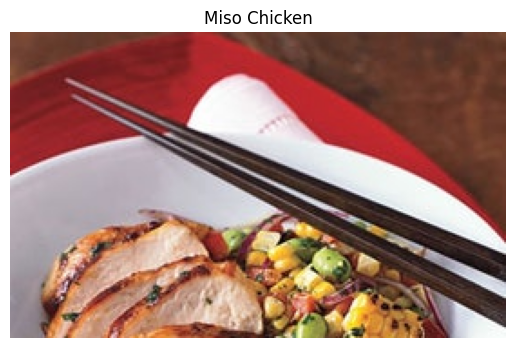



Title: Garlic-and-Rosemary Grilled Chicken with Scallions

Ingredients: ['1 3 1/2–4-pound chicken, backbone removed', 'Kosher salt, freshly ground pepper', '4 sprigs rosemary', '2 heads of garlic, halved crosswise', '2 bunches red scallions', '2 tablespoons olive oil, divided', '1 tablespoon onion or chive blossoms (optional)']

Instructions: Prepare grill for medium heat. Season chicken with salt and pepper. Place rosemary, garlic, and 1 bunch of scallions in a layer on grill.
Place chicken, skin side up, on top of aromatics. Cover grill and cook until chicken is nearly cooked through, 35–40 minutes (aromatics will be thoroughly charred).
Brush chicken with 1 tablespoon oil and place skin side down, directly onto grates (you can discard aromatics at this point). Grill until chicken is cooked through and skin is crisp, 10–15 minutes longer. Transfer to a cutting board and let rest 10 minutes before cutting into pieces.
Meanwhile, toss remaining bunch of scallions with remaining 1 tab

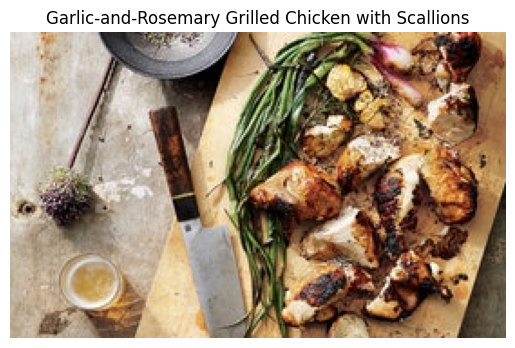



Title: Roast Chicken with Kimchi Smashed Potatoes

Ingredients: ['1 1/2 pounds fingerling or baby Yukon Gold potatoes', '4 tablespoons vegetable oil, divided', 'Kosher salt, freshly ground pepper', '4 large skin-on, bone-in chicken thighs (about 1 1/2 pounds total)', '2 garlic cloves, grated', '1 16-ounce jar Napa cabbage kimchi, drained, 1/4 cup liquid reserved', '1 tablespoon unseasoned rice vinegar', '4 cups trimmed bitter greens (such as mustard', 'mizuna', 'or arugula)']

Instructions: Preheat oven to 450°F. Toss potatoes and 1 tablespoon oil on a large rimmed baking sheet; season with salt and pepper. Roast, turning once, until browned in spots, 10-15 minutes.
Meanwhile, rub chicken with garlic and season with salt and pepper. Heat 1 tablespoon oil in a large skillet over medium-high heat. Cook chicken skin side down until golden brown and crisp, 8-10 minutes.
Arrange chicken skin side up on baking sheet among potatoes. Roast until chicken is cooked through and potatoes are ten

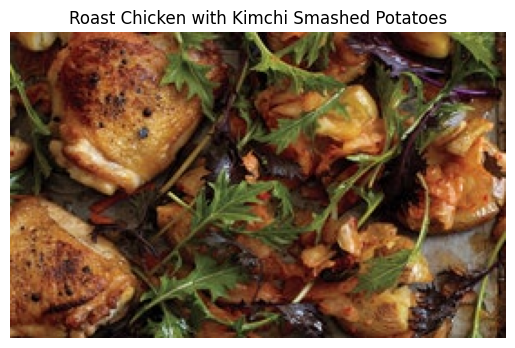



Title: Google's Braised Chicken and Kale

Ingredients: ['4 chicken legs, drumsticks and thighs separated', '1 tablespoon paprika', 'Kosher salt, freshly ground pepper', '1 teaspoon olive oil', '1 medium onion, sliced', '6 garlic cloves, sliced', '2 cups low-sodium chicken broth', '1 cup dry white wine', '2 sprigs rosemary', '2 sprigs thyme', '1 large bunch kale, center ribs and stems removed, leaves cut into 1" strips', 'Lemon wedges']

Instructions: Sprinkle chicken with paprika; season with salt and pepper. Heat oil in a large pot over medium heat. Add chicken skin side down and cook, turning occasionally, until brown on all sides, 8-10 minutes; transfer to a plate.
Add onion and garlic to pot and cook, stirring often, until softened, 8-10 minutes. Return chicken to pot; add broth, wine, and herbs. Bring to a boil; cover. Reduce heat; simmer until chicken is cooked through, 30-40 minutes.
Add kale to pot. Cover; cook until wilted, about 5 minutes. Discard herbs. Serve chicken and k

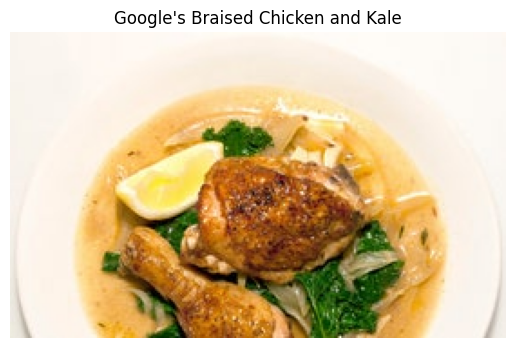



Title: Cast-Iron Roast Chicken with Winter Squash, Red Onions, and Pancetta

Ingredients: ['1 (3 1/2–4-pound) whole chicken', 'Kosher salt', '2 tablespoons unsalted butter, melted', '2 red onions, cut into wedges through root end', '2 pound winter squash (such as delicata or acorn), cut into 1 1/2-inch-thick wedges or rounds', '1 1/2 ounces pancetta, chopped into 1/4-inch pieces', '3 tablespoons olive oil, divided', 'Freshly ground black pepper']

Instructions: Pat chicken dry with paper towels and season generously with salt, inside and out. (We use 1 tsp. Diamond Crystal or 1/2 tsp. Morton kosher salt per lb.) Tie legs together with kitchen twine. Let sit 1 hour to allow salt to penetrate, or chill, uncovered, up to 1 day ahead.
Place a rack in upper third of oven and set a 12" cast-iron skillet or 3-qt. enameled cast-iron baking dish on rack. Preheat oven to 425°F.
Meanwhile, toss onions, squash, pancetta, and 2 Tbsp. oil in a large bowl to coat; season with salt and pepper.
Once 

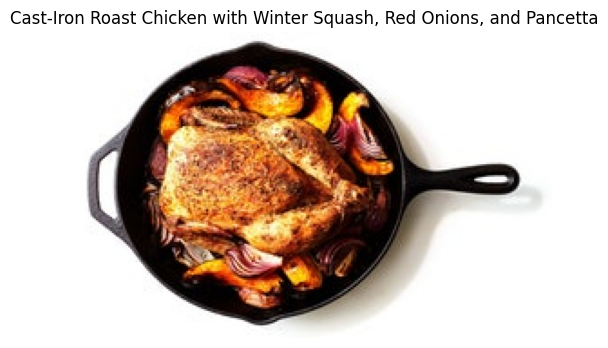

Text query results:


Title: 3-Ingredient Chicken Breasts Stuffed with Ham and Cheese

Ingredients: ['4 large boneless, skinless chicken breasts (about 2 pounds)', 'Freshly ground black pepper', '4 ounces thinly sliced Black Forest ham', '4 ounces thinly sliced Gruyère cheese', '1 tablespoon olive oil', 'Kosher salt']

Instructions: Preheat oven to 400°F. Using a sharp knife, make an incision on thinner long side of chicken breast, cutting parallel through the breast but not all the way through. Season inside of chicken with pepper and stuff each with 1 oz. ham and 1 oz. cheese.
Transfer chicken to a rimmed baking sheet and rub all over with oil; season lightly with salt and pepper. Roast chicken until an instant-read thermometer inserted into thickest part of breast registers 165°F, 12–15 minutes. Let cool slightly before slicing.


Associated Image Path: /content/drive/MyDrive/iykra/Food Images/3-ingredient-chicken-breasts-stuffed-with-ham-and-cheese.jpg


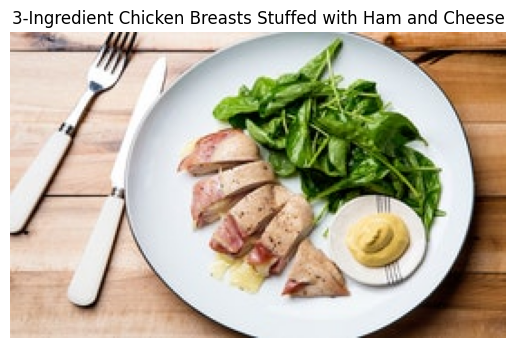



Title: Cajun-Spiced Turkey

Ingredients: ['1 12-14-pound turkey, patted dry', 'Kosher salt and freshly ground black pepper', '1 1/2 cup Cajun Spice Mix', '1 celery stalk, coarsely chopped', '1 green bell pepper, coarsely chopped', '1 medium onion, coarsely chopped', '1/4 cup (or more) olive or vegetable oil']

Instructions: Set a rack inside a large heavy roasting pan. Season turkey lightly inside and out with salt and pepper, then with spice mix, massaging it into the skin. Transfer turkey, breast side down, to prepared pan and refrigerate, uncovered, overnight.
Remove turkey from refrigerator; let stand at room temperature for 1 hour.
Preheat oven to 375°F. Mix celery, pepper, and onion in a medium bowl. Fill turkey cavities with vegetable mixture, scattering any remaining vegetables over bottom of roasting pan. Brush turkey with oil.
Roast turkey, basting occasionally, for 1 hour. Using paper towels, flip turkey. Roast, basting occasionally, until an instant-read thermometer inser

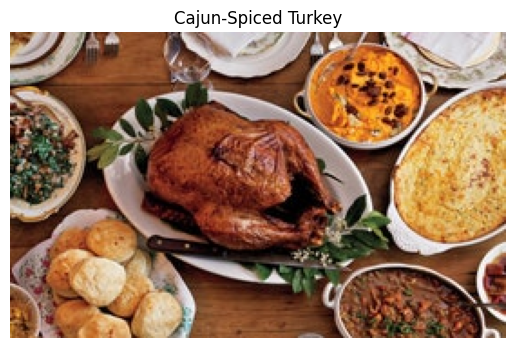



Title: Deviled Chicken Drumsticks

Ingredients: ['12 chicken drumsticks (2 1/2 to 3 pounds total)', '1/2 cup Dijon mustard', '3/4 cup panko (Japanese bread crumbs)', '3/4 cup grated Parmigiano-Reggiano (1 1/2 ounces)', '3/4 teaspoon cayenne', '3 tablespoons unsalted butter', 'melted']

Instructions: Preheat oven to 450°F with rack in upper third.
Pat chicken dry, then toss with mustard until evenly coated.
Stir together panko, cheese, cayenne, and 1/2 teaspoon each of salt and pepper. Drizzle with butter and toss.
Dredge each drumstick in crumb mixture to coat, then arrange, without crowding, in a buttered large 4-sided sheet pan. Roast until chicken is browned and cooked through, about 30 minutes. Serve warm or at room temperature.


Associated Image Path: /content/drive/MyDrive/iykra/Food Images/deviled-chicken-drumsticks-243191.jpg


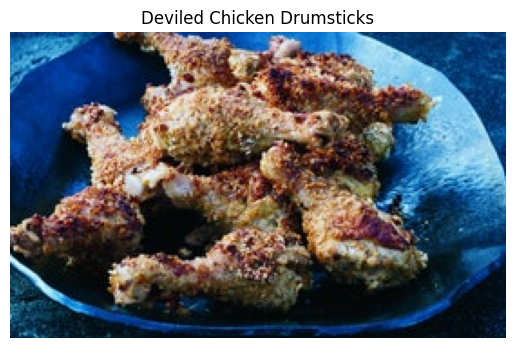



Title: Roast Chicken with Dried Fruit and Almonds

Ingredients: ['7 tablespoons olive oil, divided', '3 pounds onions, thinly sliced', '1 pound pitted prunes, halved', '12 ounces pitted dates, halved', '10 ounces dried apricot halves (about 2 cups)', '3 tablespoons sugar', '1 teaspoon ground cinnamon', '2 (4- to 4 1/2-pound) chickens, rinsed, patted dry', '1 teaspoon turmeric, divided', '1 1/2 cups (or more) water', '1/2 cup blanched slivered almonds', 'toasted']

Instructions: Heat 6 tablespoons olive oil in heavy large skillet over medium-high heat. Add onions and sauté until deep golden brown, about 30 minutes; sprinkle with salt and pepper. Transfer onions to large bowl; mix in prunes, dates, apricots, sugar, and cinnamon. Do ahead Can be made 1 day ahead. Cover and chill.
Preheat oven to 350°F. Spread fruit mixture over bottom of large roasting pan. Tuck chicken wing tips under. Rub each chicken with 1/2 tablespoon remaining olive oil and 1/2 teaspoon turmeric. Sprinkle each wit

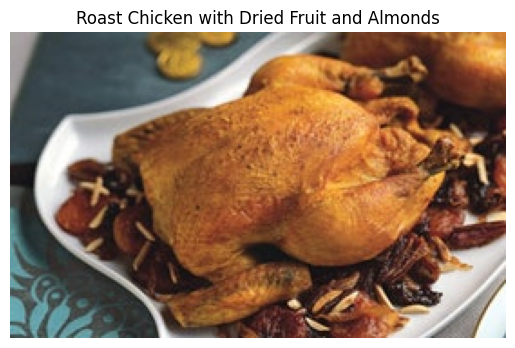



Title: Braised Chicken with Tomatoes and Olives (Poulet Provencal)

Ingredients: ['1 pound tomatoes (3 to 4 medium), cut into wedges', '1 large onion, cut into wedges, leaving root ends intact', '1/2 cup drained brine-cured black olives, pitted if desired', '4 large garlic cloves, sliced, plus 1 teaspoon minced', '3 tablespoons olive oil, divided', '2 teaspoons herbes de Provence, divided', '1/2 teaspoon fennel seeds', '1 whole chicken (about 3 1/2 pounds)', 'Equipment: kitchen string', 'Accompaniment: crusty bread', 'Garnish: chopped flat-leaf parsley']

Instructions: Preheat convection oven to 400°F or regular oven to 425°F with rack in middle.
Toss together tomatoes, onion, olives, sliced garlic, 2 tablespoons oil, 1 teaspoon herbes de Provence, fennel seeds, 1/2 teaspoon salt, and 1/4 teaspoon pepper in a 13- by 9-inch or other 3-quart shallow baking dish. Push vegetables to sides of dish to make room for chicken.
Stir together minced garlic, 1 teaspoon salt, 1/2 teaspoon pepper,

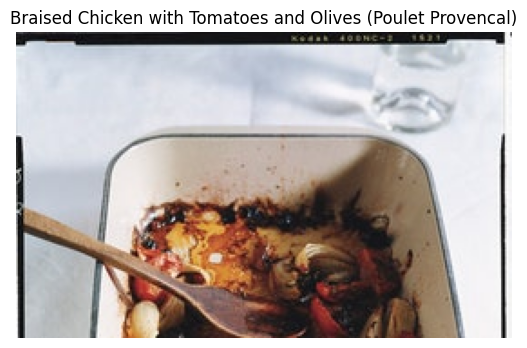

In [41]:
# Query Text functions
def generate_query_embedding(query_text):
  # Generate text embedding for the query
  query_emb = generate_text_embedding(query_text)
  return query_emb

# Function to display image with title
def display_image_with_title(image_path, title):
  try:
    img = Image.open(image_path)  # Open the image from the path
    plt.imshow(img)  # Display the image inline using matplotlib
    plt.title(title)  # Add the title above the image
    plt.axis('off')  # Hide axes
    plt.show()  # Show the image
  except Exception as e:
    print(f"Error loading image: {e}")

# Example query using ChromaDB for the text query
query_text = "roast chicken with crispy skin"
query_emb = generate_text_embedding(query_text).tolist()

# Query ChromaDB for both text and image results
results_text = collection.query(
  query_embeddings=[query_emb],
  n_results=5,  # Top 5 results
  where={"type": "text"}  # Query only text embeddings
)

# Display text query results along with associated images
print("Text query results:")
for i, res in enumerate(*results_text['metadatas']):
  # Output text metadata (like title, ingredients, etc.)
  title = res.get('title', 'N/A')
  print(f"\n\nTitle: {title}\n\nIngredients: {res.get('ingredients', 'N/A')}\n\nInstructions: {res.get('instructions', 'N/A')}\n\n")

  image_path = res.get('image_path', 'N/A')  # Get the associated image path from metadata
  if image_path != 'N/A':
    print(f"Associated Image Path: {image_path}")
    display_image_with_title(image_path, title)  # Display the image with the title

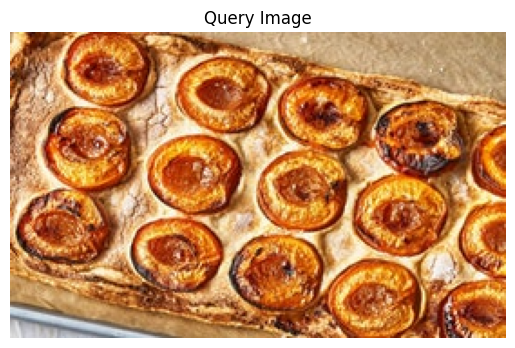

[0.38824164867401123, 0.7765979170799255, -0.3532668352127075, 0.4068216383457184, 0.40734586119651794]
Image query results:
Result 1:
  Title: Duck Fat-Potato Galette with Caraway and Sweet Onions
  Image Path: /content/drive/MyDrive/iykra/Food Images/duck-fat-potato-galette-with-caraway-and-sweet-onions-368933.jpg
  Ingredients: ['4 tablespoons (1/2 stick) unsalted butter, melted, divided, plus more for pan', '1/2 teaspoon caraway seeds', '2 tablespoons rendered duck or bacon fat, melted', '1 teaspoon (or more) kosher salt', '1/2 teaspoon freshly ground black pepper', '2 pounds medium Yukon Gold potatoes, unpeeled, cut into 1/8"-thick slices with a mandoline or V-slicer', '1 small sweet onion (such as Maui), very thinly sliced', 'Ingredient info: Rendered duck fat can be found at better supermarkets and at specialty foods stores and dartagnan.com.', 'The outer ring from a 9"-diameter springform pan']
  Instructions: Arrange a rack in middle of oven; preheat to 425°F. Brush a foil- or

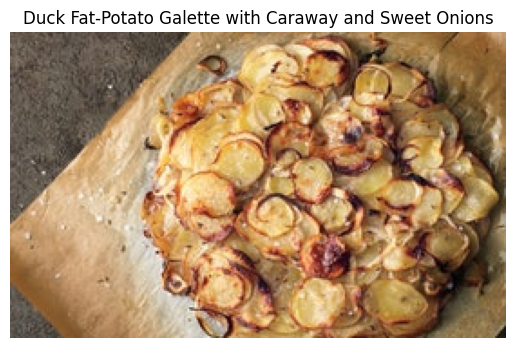

Result 2:
  Title: Peach Dutch Baby Pancake with Cherry Compote
  Image Path: /content/drive/MyDrive/iykra/Food Images/peach-dutch-baby-pancake-with-cherry-compote-51108600.jpg
  Ingredients: ['1/4 cup honey', '2 (3-inch) strips lemon peel', '1 tablespoon fresh lemon juice', '2 cups fresh (or frozen, thawed) cherries (about 1 pound), stemmed, pitted, halved', '4 tablespoons (1/2 stick) unsalted butter, divided', '4 large eggs', '3/4 cup all-purpose flour', '3/4 cup whole milk', '3 tablespoons sugar, divided', '1 teaspoon vanilla extract', '1/4 teaspoon kosher salt', '2 peaches, halved, pitted, cut into 1/4"-thick wedges', 'Powdered sugar (for dusting)']
  Instructions: Bring honey, lemon peel, lemon juice, and 1/2 cup water to a boil in a small heavy saucepan. Add cherries and simmer briskly, stirring occasionally, until sauce is syrupy, about 15 minutes. Transfer cherry compote to a medium bowl and chill.
Preheat oven to 425°F. Melt 2 tablespoons butter in a small saucepan; scrape int

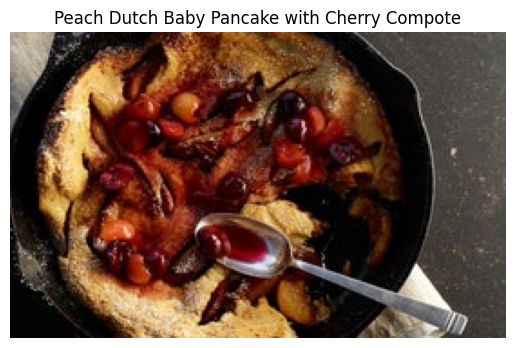

Result 3:
  Title: Southern "One-Cup" Peach Cobbler
  Image Path: /content/drive/MyDrive/iykra/Food Images/southern-one-cup-peach-cobbler.jpg
  Ingredients: ['1 1/2 lb. peaches, pitted, cut into 1/2"-thick wedges', '2 tsp. finely grated lemon zest', '1/4 cup fresh lemon juice', '1 cup sugar, divided', '3/4 tsp. kosher salt, divided', '1/2 cup (1 stick) unsalted butter', '1 cup all-purpose flour', '1 1⁄2 tsp. baking powder', '1 cup whole milk', '1 tsp. vanilla extract', 'Vanilla ice cream or whipped cream (for serving; optional)']
  Instructions: Toss peaches, lemon zest, lemon juice, 1/4 cup sugar, and 1/4 tsp. salt in a large bowl. Let sit, stirring occasionally, until saucy, about 15 minutes.
Preheat oven to 350°F. Place butter in a 13x9" glass or ceramic baking dish and heat in oven until melted, 8–10 minutes. Remove pan from oven.
Meanwhile, whisk flour, baking powder, and remaining 3/4 cup sugar and 1/2 tsp. salt in another large bowl. Add milk and vanilla and whisk until batter i

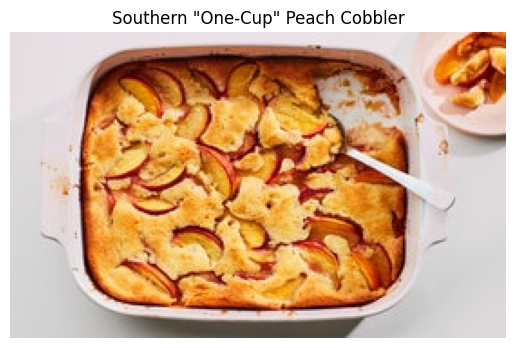

Result 4:
  Title: Maple-Roasted Acorn Squash
  Image Path: /content/drive/MyDrive/iykra/Food Images/maple-roasted-acorn-squash-ina-garten.jpg
  Ingredients: ['3 acorn squash, unpeeled, halved through the stem, and seeded', '3 tablespoons unsalted butter, diced', '3 tablespoons pure maple syrup, plus extra for serving', 'Good olive oil', 'Kosher salt and freshly ground black pepper', 'Flaked sea salt', 'such as Maldon', 'for serving']
  Instructions: Preheat the oven to 350°F.
Place the squash, cut sides up, on a sheet pan. Place ½ tablespoon butter and ½ tablespoon maple syrup in the cavity of each squash. Brush the cut sides with olive oil and sprinkle the squash with 3 teaspoons kosher salt and 1 teaspoon pepper. Roast for 40 to 60 minutes, depending on the size of the squash, until tender when pierced with a small knife.
Place the squash on a serving platter. If the halves are too large for one serving, cut each piece in half through the stem. Drizzle lightly with extra maple syrup

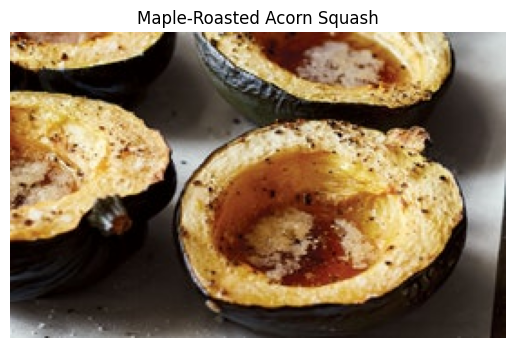

Result 5:
  Title: Syrniki (Сырники / Farmer’s Cheese Pancakes)
  Image Path: /content/drive/MyDrive/iykra/Food Images/farmers-cheese-pancakes-syrniki.jpg
  Ingredients: ['2 egg yolks', '2 cups (1 pound) tvorog or farmer’s cheese, homemade or store-bought', 'Scant 1⁄2 cup sugar', '3⁄4 cup flour', '1⁄2 teaspoon baking powder', 'Pinch of salt', 'A tablespoon or two of heavy cream (optional)', '2 tablespoons unsalted butter', '2 tablespoons vegetable oil', 'Sour cream', 'for garnish']
  Instructions: In a medium bowl, beat the egg yolks into the farmer’s cheese, then stir in the sugar. Mix together 1⁄2 cup of the flour, the baking powder, and the salt and add to the cheese mixture. If the mixture seems dry, add a little heavy cream.
Place the butter and oil over medium-low heat in a large nonstick skillet and melt the butter.
Sprinkle the remaining 1⁄4 cup flour onto a plate and dust your hands with some flour, too. With your hands or a spoon, scoop out about 2 tablespoons of the batter a

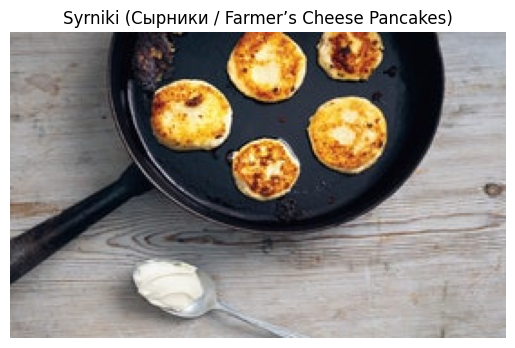

In [80]:
# Query Image Function
def generate_query_image_embedding(query_image_path):
    # Generate image embedding for the query image
    query_img_emb = generate_image_embedding(query_image_path)  # Use query_image_path here
    return query_img_emb.tolist()

# Example query using ChromaDB for the image query
query_image = df['Image_Path'].iloc[1908]

# Generate the embedding for the query image
query_img_emb = generate_query_image_embedding(query_image)

# Optionally, display the query image
display_image_with_title(query_image, 'Query Image')
print(query_img_emb[:5])

# Query ChromaDB for image results
results_img = collection.query(
    query_embeddings=[query_img_emb],
    n_results=5,  # Top 5 results
    where={"type": "image"}  # Query only image embeddings
)

# Display image query results along with associated images
print("Image query results:")
if results_img:
    for idx, result in enumerate(*results_img['metadatas']):
        print(f"Result {idx + 1}:")
        print(f"  Title: {result['title']}")
        print(f"  Image Path: {result['image_path']}")
        print(f"  Ingredients: {result['ingredients']}")
        print(f"  Instructions: {result['instructions']}")
        # Optionally, display image using the path
        display_image_with_title(result['image_path'], result['title'])
else:
    print("No results found.")


# Augmenting and Generation

## Text input

In [340]:
# Function to retrieve image or text
def retrieve_from_text(query):
  # Clean the query to focus on nouns and adjectives
  query_emb = generate_text_embedding(query).tolist()
  results = collection.query(
    query_embeddings=[query_emb],
    n_results=3,
    where={"type": "text"}
  )
  result = results['metadatas'][0]
  return result

initial_template = ChatPromptTemplate.from_template("""
Translate this into english: {context} and keep it in your mind. Don't write the translated text.
However, write the most suitable food based on that.
Answer only in 1 food nouns plus adjectives (can be multiple adjectives). Remember only 1 food nouns.
Separate them with commas. No structured sentences.
""")

prompt_template = ChatPromptTemplate.from_template("""
You are cuisine expert in making people drool by your food recommendation.
You will help people decide what is the best dish from these 3.
Do not get out from these 3 dishes, ingredients and instructions.

First Dish name: {title0}
First Ingredients: {ingredients0}
First Instructions: {instructions0}

Second Dish name: {title1}
Second Ingredients: {ingredients1}
Second Instructions: {instructions1}

Third Dish name: {title2}
Third Ingredients: {ingredients2}
Third Instructions: {instructions2}

Here is their original question and context: {context}

Persuade them to try among these dishes while still sound natural and not too exagerrating.
Enrich your output by using ingredients and the context provided as necessary.
Phrase it so if you disagree with dishes above, put them later in your paragraph and persuade them to try them if they want something outside their preferences.
People have been already given the picture of the 3 dishes above.
If they are unsatisfied with the result, ask them to tell you more about the ingredients, cooking methods or instructions.
Add newline after each sentences. Answer in bahasa Indonesia
""")

llm1 = ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b", google_api_key=GOOGLE_API_KEY, max_tokens=20, temperature=0)
llm2 = ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b", google_api_key=GOOGLE_API_KEY, max_tokens=500, temperature=0.5)

initial_text_chain = (
    initial_template
    | llm1
    | StrOutputParser()
)

text_chain = (
    RunnableMap({'initial': initial_text_chain,'context': RunnablePassthrough()})
    | {
        "title0": lambda x: retrieve_from_text(x['initial'])[0]['title'],
        "ingredients0": lambda x: retrieve_from_text(x['initial'])[0]['ingredients'],
        "instructions0": lambda x: retrieve_from_text(x['initial'])[0]['instructions'],
        "title1": lambda x: retrieve_from_text(x['initial'])[1]['title'],
        "ingredients1": lambda x: retrieve_from_text(x['initial'])[1]['ingredients'],
        "instructions1": lambda x: retrieve_from_text(x['initial'])[1]['instructions'],
        "title2": lambda x: retrieve_from_text(x['initial'])[2]['title'],
        "ingredients2": lambda x: retrieve_from_text(x['initial'])[2]['ingredients'],
        "instructions2": lambda x: retrieve_from_text(x['initial'])[2]['instructions'],
        "context": RunnablePassthrough(),
      }
    | prompt_template
    | llm2
    | StrOutputParser()
)

In [303]:
df['Title'].iloc[np.random.randint(0,len(df))]

'Spring Pea Frittata'

In [351]:
# Input Text
user_query = "Lagi kepingin kue tapi kopi. Ada ga ya?"
print(initial_text_chain.invoke(user_query))
# Query ChromaDB for both text and image results
results_text = retrieve_from_text(initial_text_chain.invoke(user_query))

# Prepare a list to store widgets for the images
image_widgets = []

for i, res in enumerate(results_text):
  # Output text metadata (like title, ingredients, etc.)
  title = res.get('title', 'N/A')
  image_path = res.get('image_path', 'N/A')  # Get the associated image path from metadata

  # Create a widget to display the image and title if image path exists
  if image_path != 'N/A':
    image_widget = widgets.Image(value=open(image_path, 'rb').read(), format='png')
    title_widget = widgets.Label(value=title)

    # Combine title and image in a vertical layout
    vbox = widgets.VBox([image_widget, title_widget])
    image_widgets.append(vbox)

# Stack the images horizontally
if image_widgets:
  hbox = widgets.HBox(image_widgets)
  display(hbox)
else:
  print("No images to display.")

query_result = text_chain.invoke(user_query)
print(query_result)

Coffee, cake



Hmm, kopi dan kue... kombinasi yang sempurna!  Dari ketiga pilihan ini, aku sarankan kamu coba **Colomba Easter Zuppa Inglese**.  Bayangkan, Colomba yang lembut, dipadukan dengan potongan buah peach yang segar, dan krim mascarpone yang creamy.  Rasanya pasti unik dan menyegarkan, cocok banget untuk menemani kopi panasmu.  Teksturnya juga berlapis-lapis, seperti makan kue tapi juga seperti dessert yang mewah.  Terlebih lagi, ada potongan cokelat telur Paskah Italia yang menambah cita rasa dan tampilan yang cantik.  


Bahan-bahannya juga menarik, seperti buah peach, krim, dan tentunya Colomba.  Rasanya pasti berpadu harmonis dengan kopi.  


Kalau kamu tertarik dengan kue yang lebih klasik, mungkin **Coconut Cake** juga bisa menjadi pilihan yang bagus.  Teksturnya lembut dan harum, dengan cita rasa kelapa yang khas.  Kue ini pasti akan membuatmu kenyang dan berkesan.


Terakhir, ada **Carrot Cake**.  Cake wortel ini juga punya cita rasa yang unik dan lezat.  Dengan campuran wortel, remp

## Image input

In [330]:
# Function to retrieve image
def retrieve_from_image(query_image_path):
  # Generate image embedding for the query image
  query_img_emb = generate_image_embedding(query_image_path)  # Use query_image_path here
  query_img_emb = query_img_emb.tolist()
  results_img = collection.query(
    query_embeddings=[query_img_emb],
    n_results=3,
    where={"type": "image"}  # Query only image embeddings
  )
  return results_img['metadatas'][0]


image_prompt_template = ChatPromptTemplate.from_template("""
You are cuisine expert in making people drool by your food recommendation.
You will help people decide what is the best dish from these 3.
Do not get out from these 3 dishes.

Dish name: {title0}
Ingredients: {ingredients0}
Instructions: {instructions0}

Dish name: {title1}
Ingredients: {ingredients1}
Instructions: {instructions1}

Dish name: {title2}
Ingredients: {ingredients2}
Instructions: {instructions2}

Persuade them to try among these dishes while still sound natural and not too exagerrating.
Enrich your output by using ingredients as necessary.
Phrase it so if you disagree with dishes above, put them later in your paragraph and persuade them to try them if they want something outside their preferences.
People have been already given the picture of the 3 dishes above.
If they are unsatisfied with the result, ask them to tell you more about the ingredients, cooking methods or instructions.
Add newline after each sentences. Answer in bahasa Indonesia
""")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b", google_api_key=GOOGLE_API_KEY, max_tokens=500, temperature=0.3)

image_chain = (
    {
        "title0": lambda x: retrieve_from_image(x)[0]['title'],
        "ingredients0": lambda x: retrieve_from_image(x)[0]['ingredients'],
        "instructions0": lambda x: retrieve_from_image(x)[0]['instructions'],
        "title1": lambda x: retrieve_from_image(x)[1]['title'],
        "ingredients1": lambda x: retrieve_from_image(x)[1]['ingredients'],
        "instructions1": lambda x: retrieve_from_image(x)[1]['instructions'],
        "title2": lambda x: retrieve_from_image(x)[2]['title'],
        "ingredients2": lambda x: retrieve_from_image(x)[2]['ingredients'],
        "instructions2": lambda x: retrieve_from_image(x)[2]['instructions'],
        "context": RunnablePassthrough(),
    }
    | image_prompt_template
    | llm
    | StrOutputParser()
)

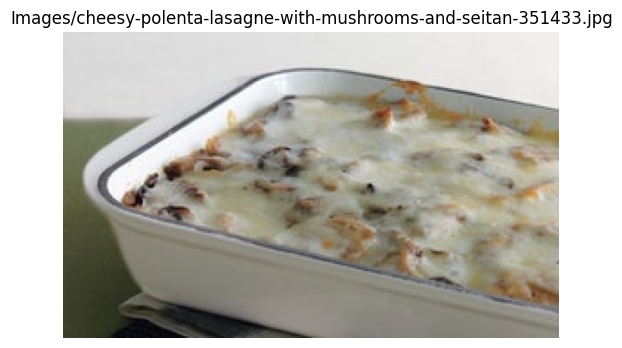




Wow, melihat ketiga hidangan ini membuatku ingin segera mencicipinya!  Ketiga resepnya terlihat begitu menggugah selera, masing-masing dengan cita rasa dan tekstur yang unik.  Mari kita bahas satu per satu.


Pertama, ada Apple, Potato, dan Onion Gratin.  Bayangkan potongan-potongan apel Granny Smith yang segar, berpadu dengan kentang Yukon Gold yang lembut, dan bawang bombay yang manis.  Aroma thyme yang harum akan membangkitkan selera makan Anda.  Teksturnya yang lembut dan rasa yang seimbang, tanpa tambahan krim atau keju, akan membuat Anda terkesan.  Ini adalah hidangan yang sempurna untuk makan malam yang santai dan penuh cita rasa musim gugur.


Kedua, ada Corn Pudding dengan Mushrooms and Ham.  Hidangan ini menggabungkan rasa manis jagung segar dengan jamur yang gurih dan ham yang asin.  Tekstur puding yang lembut dan creamy, dipadukan dengan aroma jamur dan ham yang kaya, pasti akan membuat Anda ingin mencobanya.  Ditambah dengan Parmesan yang ditaburkan di atasnya, hidangan

In [350]:
# Input Text
image_path = df['Image_Path'].iloc[np.random.randint(0,len(df))]

# Display query Image
display_image_with_title(image_path, image_path.split()[-1])
print('\n\n')
query_result = image_chain.invoke(image_path)
print(query_result)

# Query ChromaDB for both text and image results
results_image = retrieve_from_image(image_path)

# Prepare a list to store widgets for the images
image_widgets = []

for i, res in enumerate(results_image):
  # Output text metadata (like title, ingredients, etc.)
  title = res.get('title', 'N/A')
  image_path = res.get('image_path', 'N/A')  # Get the associated image path from metadata

  # Create a widget to display the image and title if image path exists
  if image_path != 'N/A':
    image_widget = widgets.Image(value=open(image_path, 'rb').read(), format='png')
    title_widget = widgets.Label(value=title)

    # Combine title and image in a vertical layout
    vbox = widgets.VBox([image_widget, title_widget])
    image_widgets.append(vbox)

# Stack the images horizontally
if image_widgets:
  hbox = widgets.HBox(image_widgets)
  display(hbox)
else:
  print("No images to display.")